In [ ]:
import io
import pandas as pd
from google.colab import files

uploaded = files.upload()


Saving harga-crawler-all (1).csv to harga-crawler-all (1).csv


In [ ]:


df = pd.read_csv(io.BytesIO(uploaded['harga-crawler-all (1).csv']), index_col='tgl', parse_dates=True)

df.head()

,komoditas,area_provinsi,area_kota,size,price,tgl_parsed,timestamp,source
tgl,,,,,,,,
2020-09-07,lele,Jawa Barat,Cirebon,4.0,NaN,2020-09-06T17:00:00.000Z,1599436800,kso-suganda
2020-09-07,lele,Jawa Barat,Cirebon,8.0,NaN,2020-09-06T17:00:00.000Z,1599436800,kso-suganda
2020-09-07,udang,JAWA TIMUR,PACITAN,60.0,72000.0,2020-09-06T17:00:00.000Z,1599411600,jala
2020-09-07,udang,JAWA TIMUR,PACITAN,70.0,69000.0,2020-09-06T17:00:00.000Z,1599411600,jala
2020-09-07,udang,JAWA TIMUR,PACITAN,80.0,66000.0,2020-09-06T17:00:00.000Z,1599411600,jala


In [ ]:
# import pandas_profiling
# from pandas_profiling import ProfileReport
# from pandas_profiling.utils.cache import cache_file

df2.drop(['size','price','timestamp','komoditas','area_provinsi','area_kota','tgl_parsed', 'timestamp', 'source'], axis=1)
df2 = df[(df['komoditas'] != 'lele') & (df['komoditas'] != '-')]
df2['sales_value'] = df2.size * df2.price

df2.head()



Text(0, 0.5, 'daily sales')

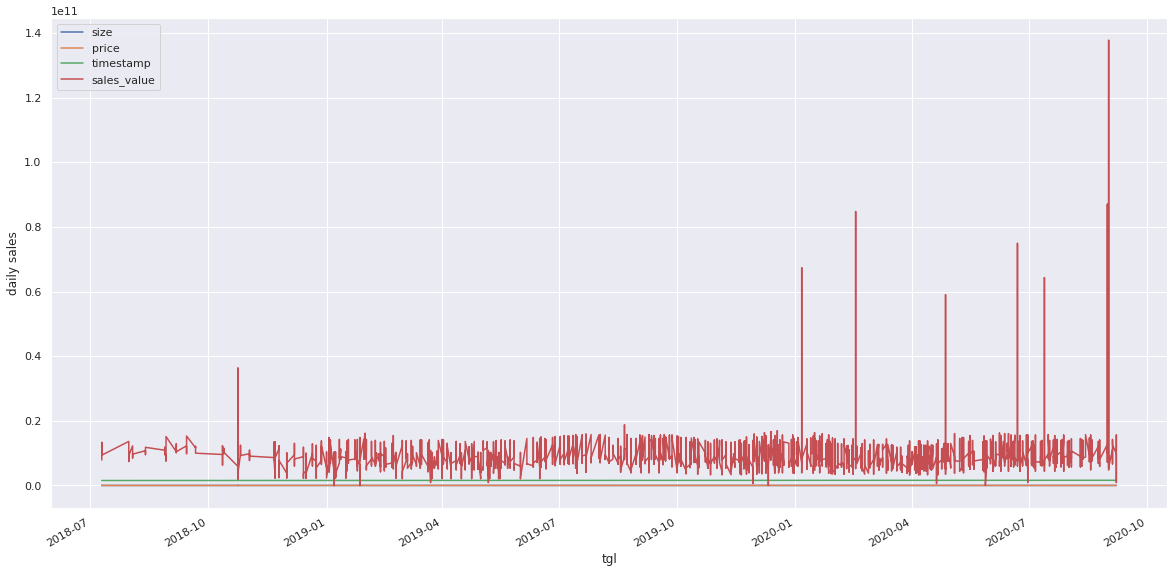

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

df2.plot(figsize=(20,10))
plt.ylabel('daily sales')

In [ ]:
# we try to resample weekly, want to see the uncertainty of populattion

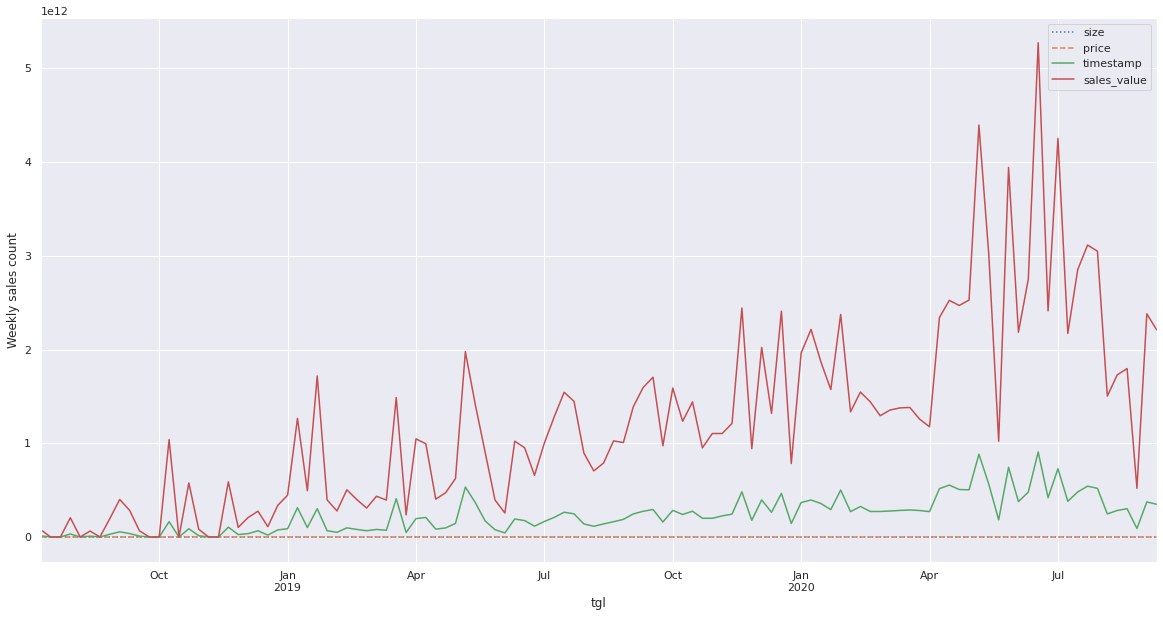

In [ ]:
weekly = df2.resample('W').sum()
weekly.plot(style=[':','--','-'],figsize=(20,10))
plt.ylabel('Weekly sales count');

In [ ]:
# let's compare to daily aggregation

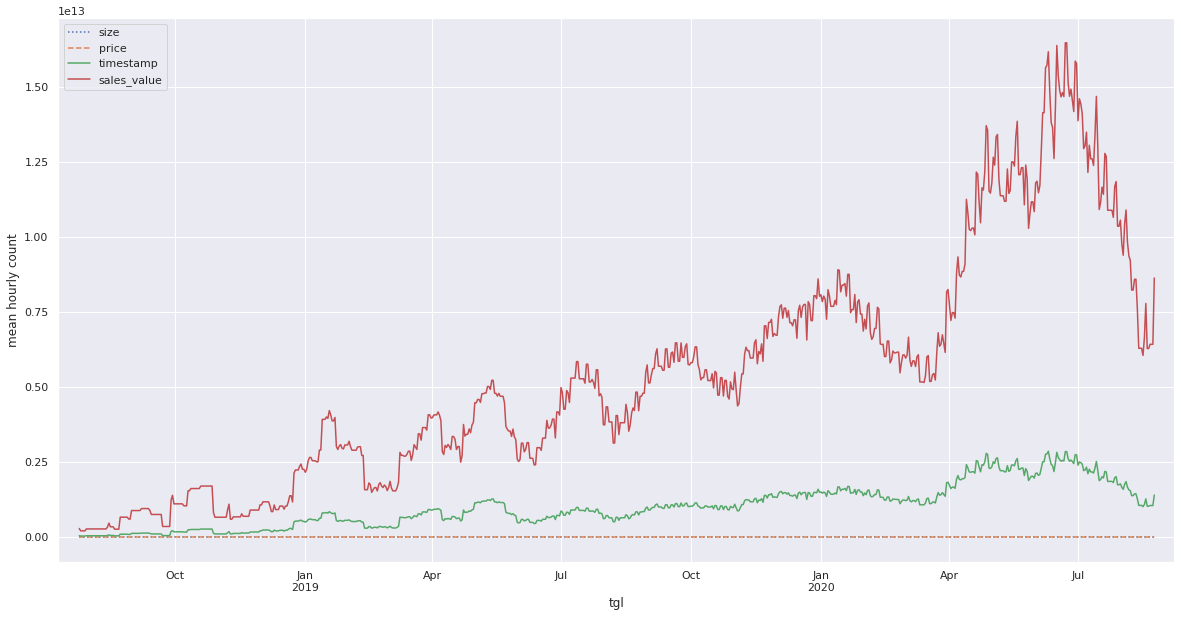

In [ ]:
daily = df2.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'], figsize=(20,10))
plt.ylabel('mean hourly count');

In [ ]:
# the result is still jagged. We need to find smoother versioin of rolling mean using window function. 

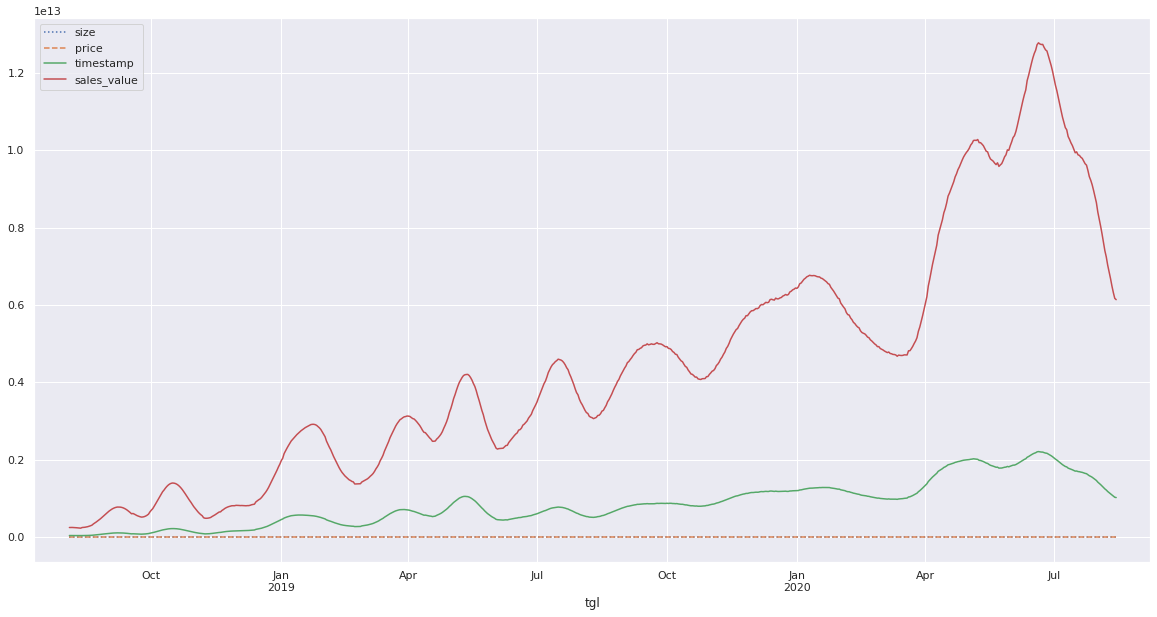

In [ ]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-'],figsize=(20,10));

In [ ]:
# Above chart look the same with previous one, but with different scale
# When working with time-series data, its good to take a look at the data 
# to determine if trends exist, whether it is stationary, has any outliers 
# and/or any other anamolies. Facebook prophet's example uses the log-transform
# as a way to remove some of these anomolies but it isn't the absolute 'best' way
# to do this...but given that its the example and a simple data series,
# I'll follow their lead for now. Taking the log of a number is easily reversible to be able to see your original data.

In [ ]:
# Prophet is a procedure for forecasting time series data based on an additive model where
# non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
# It works best with time series that have strong seasonal effects and several seasons of historical data.
# Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
df2 = df2.rename(columns={'tgl':'ds', 'sales_value':'y'})
df2 = df2.drop(columns=['level_0','index'], axis=1)
df2.head()

In [ ]:
df2['y'] = np.log(df2['y'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log



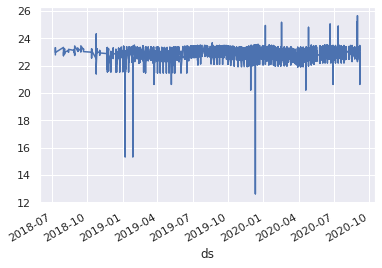

In [ ]:
df2.set_index('ds').y.plot()

In [ ]:
# now let's setup prophet to model the data

In [ ]:
from fbprophet import Prophet

#drop infinite values in df
data = data.replace([np.inf, -np.inf], np.nan)

model = Prophet()
model.fit(data);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
16841,2022-04-30
16842,2022-05-31
16843,2022-06-30
16844,2022-07-31
16845,2022-08-31


In [ ]:
forecast = model.predict(future)


In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
16841,2022-04-30,22.908538,16.957734,28.710238,17.160834,28.731721,-0.166610,-0.166610,-0.166610,-0.049974,-0.049974,-0.049974,-0.116636,-0.116636,-0.116636,0.0,0.0,0.0,22.741928
16842,2022-05-31,22.910575,16.738671,29.266423,16.685386,29.306302,0.000407,0.000407,0.000407,-0.042419,-0.042419,-0.042419,0.042825,0.042825,0.042825,0.0,0.0,0.0,22.910981
16843,2022-06-30,22.912546,16.296522,29.780720,16.223321,29.729527,0.115153,0.115153,0.115153,0.065939,0.065939,0.065939,0.049214,0.049214,0.049214,0.0,0.0,0.0,23.027699
16844,2022-07-31,22.914582,15.820799,30.443583,15.763870,30.205396,0.082039,0.082039,0.082039,0.000639,0.000639,0.000639,0.081400,0.081400,0.081400,0.0,0.0,0.0,22.996621
16845,2022-08-31,22.916619,15.329667,30.720394,15.303741,30.710320,-0.004988,-0.004988,-0.004988,-0.077346,-0.077346,-0.077346,0.072358,0.072358,0.072358,0.0,0.0,0.0,22.911631


In [ ]:
# We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:
# yhat : forecast
# yhat lower & yhat upper : uncertainty interval

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
16841,2022-04-30,22.741928,16.957734,28.710238
16842,2022-05-31,22.910981,16.738671,29.266423
16843,2022-06-30,23.027699,16.296522,29.780720
16844,2022-07-31,22.996621,15.820799,30.443583
16845,2022-08-31,22.911631,15.329667,30.720394


In [ ]:
# plot the prophet result

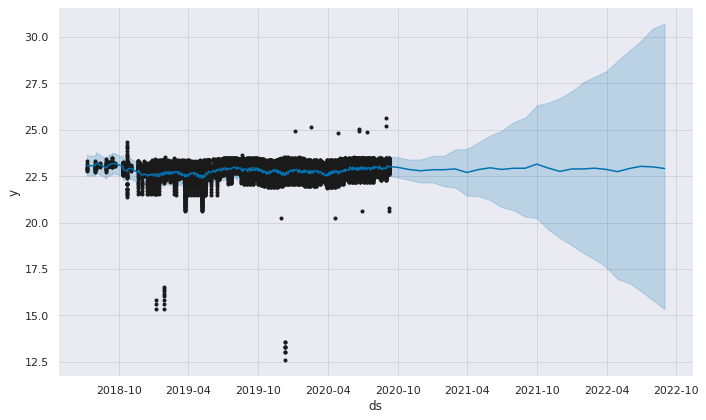

In [ ]:
model.plot(forecast);


In [ ]:
# combine our model VS our original data, then combine the output with original

In [ ]:
data.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

In [ ]:
# Now, we'll combine the original data and our forecast model data

In [ ]:

viz_df = data.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [ ]:
viz_df.head()


,y,yhat,yhat_lower,yhat_upper
ds,,,,
2018-07-10,23.31276,23.060917,22.522329,23.623161
2018-07-10,23.31276,23.060917,22.535373,23.623556
2018-07-10,23.31276,23.060917,22.535604,23.608376
2018-07-10,23.31276,23.060917,22.526493,23.620698
2018-07-10,23.31276,23.060917,22.540974,23.598374


In [ ]:
# The scales we use area different (original vs model)
# we need to rescale it again on yhat columns to get the same scale, we'll use exp (reverse from log)

In [ ]:
viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])
viz_df.head()


,y,yhat,yhat_lower,yhat_upper,yhat_scaled,yhat_rescaled
ds,,,,,,
2018-07-10,23.312760,NaN,NaN,NaN,NaN,NaN
2018-07-10,23.152911,NaN,NaN,NaN,NaN,NaN
2018-07-10,23.040115,NaN,NaN,NaN,NaN,NaN
2018-07-10,22.962557,NaN,NaN,NaN,NaN,NaN
2018-07-10,22.929767,NaN,NaN,NaN,NaN,NaN


In [ ]:
# put together 

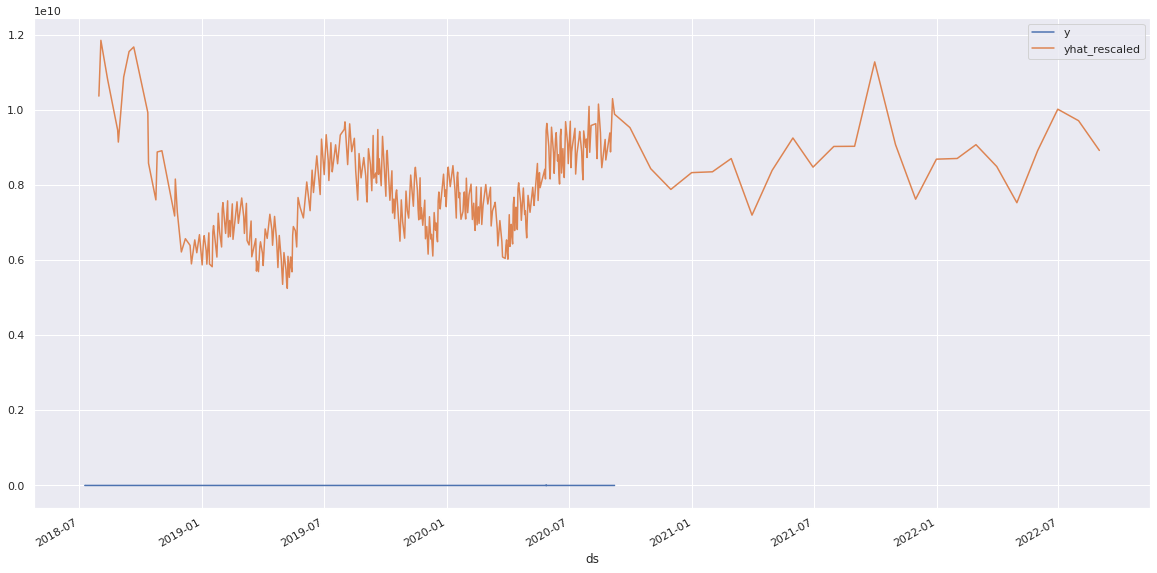

In [ ]:
viz_df[['y', 'yhat_rescaled']].plot(figsize=(20,10))

In [ ]:

data.index = pd.to_datetime(data.index) #make sure our index as a datetime object
connect_date = data.index[-2] #select the 2nd to last date

In [ ]:
mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]


In [ ]:
predict_df.head()


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2018-07-31,23.022957,22.543053,23.597262,23.022957,23.022957,0.038981,0.038981,0.038981,-0.042419,-0.042419,-0.042419,0.0814,0.0814,0.0814,0.0,0.0,0.0,23.061938
2018-07-31,23.022957,22.557068,23.588673,23.022957,23.022957,0.038981,0.038981,0.038981,-0.042419,-0.042419,-0.042419,0.0814,0.0814,0.0814,0.0,0.0,0.0,23.061938
2018-07-31,23.022957,22.557257,23.597098,23.022957,23.022957,0.038981,0.038981,0.038981,-0.042419,-0.042419,-0.042419,0.0814,0.0814,0.0814,0.0,0.0,0.0,23.061938
2018-07-31,23.022957,22.508595,23.588416,23.022957,23.022957,0.038981,0.038981,0.038981,-0.042419,-0.042419,-0.042419,0.0814,0.0814,0.0814,0.0,0.0,0.0,23.061938
2018-07-31,23.022957,22.516291,23.611578,23.022957,23.022957,0.038981,0.038981,0.038981,-0.042419,-0.042419,-0.042419,0.0814,0.0814,0.0814,0.0,0.0,0.0,23.061938


In [ ]:
viz_df = data.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])

In [ ]:
viz_df.head()


,y,yhat,yhat_lower,yhat_upper,yhat_scaled
ds,,,,,
2018-07-10,23.312760,NaN,NaN,NaN,NaN
2018-07-10,23.152911,NaN,NaN,NaN,NaN
2018-07-10,23.040115,NaN,NaN,NaN,NaN
2018-07-10,22.962557,NaN,NaN,NaN,NaN
2018-07-10,22.929767,NaN,NaN,NaN,NaN


In [ ]:
viz_df.tail()


,y,yhat,yhat_lower,yhat_upper,yhat_scaled
ds,,,,,
2022-04-30,NaN,22.741928,16.957734,28.710238,7.528249e+09
2022-05-31,NaN,22.910981,16.738671,29.266423,8.914823e+09
2022-06-30,NaN,23.027699,16.296522,29.780720,1.001850e+10
2022-07-31,NaN,22.996621,15.820799,30.443583,9.711931e+09
2022-08-31,NaN,22.911631,15.329667,30.720394,8.920615e+09


IndexError: ignored

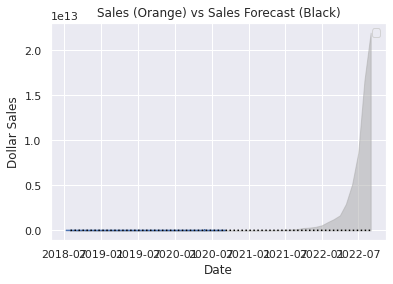

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.y)
ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Sales (  ) vs Sales Forecast (Black)')
ax1.set_ylabel('Dollar Sales')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('Actual Sales')
L.get_texts()[1].set_text('Forecasted Sales') 